# import & PCA

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as skPCA
from sklearn.metrics import r2_score,classification_report, accuracy_score

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [14]:
class PCA:
    def __init__(self,n_components=2,axis=0):
        self.n_components=n_components
        self.axis=axis

    def fit(self,X):
        if self.axis==0:
            U,Sigma,V_T=np.linalg.svd(X)
        else:
            U,Sigma,V_T=np.linalg.svd(X.T)
        eigs=Sigma*Sigma
        sumVar=eigs.sum()
        self.explained_variance_ratio_=eigs/sumVar
        if self.n_components<1:
            self.n_components=\
                int(np.ceil(self.n_components*len(Sigma)))
        self.W=V_T.T[:,:self.n_components]
    
    def transform(self,X):
        if self.axis==0:
            return X@self.W
        else:
            return self.W.T@X
    
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)


In [25]:
def imgPCA(img,n_components=2,gray=False):
    if gray==True:
        if n_components<1:
            rank=np.linalg.matrix_rank(img)
            n_components=int(np.ceil(rank*n_components))
        model=skPCA(n_components)
        reduced_img=model.fit_transform(img)
        cimg=model.inverse_transform(reduced_img)
    else:
        cimg=np.empty(img.shape,dtype='uint8')
        for channel in range(4):
            if n_components<1:
                rank=np.linalg.matrix_rank(img[:,:,channel])
                n_components=int(np.ceil(rank*n_components))
            model=skPCA(n_components)
            reduced_img=model.fit_transform(img[:,:,channel])
            cimg[:,:,channel]=model.inverse_transform(reduced_img)
    return cimg

# Iris

In [16]:
from sklearn.datasets import load_iris

# import dataset
iris=load_iris()

# standard scale
iris_scaler=StandardScaler().fit(iris.data)
X=iris_scaler.transform(iris.data)

In [17]:
model=PCA(n_components=3)
pca_X=model.fit_transform(X)

# compare with sklearn
skmodel=skPCA(n_components=3)
sk_X=skmodel.fit_transform(X)
print('explained variance ratio: ',model.explained_variance_ratio_)
print(pca_X[:5,:],sk_X[:5,:],sep='\n'+'-'*50+'\n')

explained variance ratio:  [0.72962445 0.22850762 0.03668922 0.00517871]
[[-2.26470281 -0.4800266   0.12770602]
 [-2.08096115  0.67413356  0.23460885]
 [-2.36422905  0.34190802 -0.04420148]
 [-2.29938422  0.59739451 -0.09129011]
 [-2.38984217 -0.64683538 -0.0157382 ]]
--------------------------------------------------
[[-2.26470281  0.4800266  -0.12770602]
 [-2.08096115 -0.67413356 -0.23460885]
 [-2.36422905 -0.34190802  0.04420148]
 [-2.29938422 -0.59739451  0.09129011]
 [-2.38984217  0.64683538  0.0157382 ]]


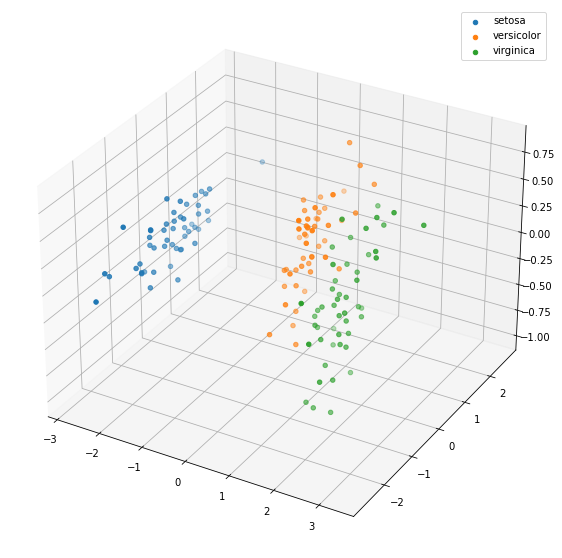

In [18]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection="3d")
ax.scatter(pca_X[iris.target==0,0],pca_X[iris.target==0,1],pca_X[iris.target==0,2],'r')
ax.scatter(pca_X[iris.target==1,0],pca_X[iris.target==1,1],pca_X[iris.target==1,2],'g')
ax.scatter(pca_X[iris.target==2,0],pca_X[iris.target==2,1],pca_X[iris.target==2,2],'b')
ax.legend(iris.target_names)
plt.savefig('iris.png')
plt.show()

# Digits

In [19]:
from sklearn.datasets import load_digits

digits=load_digits()

digits_scaler=StandardScaler().fit(digits.data)
X=digits_scaler.transform(digits.data)

In [20]:
X_train,X_test,Y_train,Y_test=\
    train_test_split(X,digits.target,random_state=1,train_size=0.6)
raw_SVM=LinearSVC(random_state=1,dual=False)
raw_SVM.fit(X_train,Y_train)
Y_pred=raw_SVM.predict(X_test)
score=r2_score(Y_test,Y_pred)
print('>'*20+' Directly use SVM '+'<'*20)
print('r2 score: ',r2_score(Y_test,Y_pred))
print('accuracy score: ',accuracy_score(Y_test,Y_pred))
print('classification report:\n',
    classification_report(Y_test,Y_pred))

rate_list=[0.01,0.05,0.1,0.3,0.6,0.8]
for i in range(6):
    rate=rate_list[i]
    PCA_model=PCA(n_components=rate)
    pca_X=PCA_model.fit_transform(X)
    X_train,X_test,Y_train,Y_test=\
        train_test_split(pca_X,digits.target,random_state=1,train_size=0.6)
    PCA_SVM=LinearSVC(random_state=1,dual=False)
    PCA_SVM.fit(X_train,Y_train)
    Y_pred=PCA_SVM.predict(X_test)
    print('>'*20+f' PCA ({int(100*rate)}%) '+'<'*20)
    print('r2 score: ',r2_score(Y_test,Y_pred))
    print('accuracy score: ',accuracy_score(Y_test,Y_pred))
    print('classification report:\n',
        classification_report(Y_test,Y_pred))

>>>>>>>>>>>>>>>>>>>> Directly use SVM <<<<<<<<<<<<<<<<<<<<
r2 score:  0.85653678244688
accuracy score:  0.9554937413073713
classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        74
           1       0.91      0.94      0.93        68
           2       1.00      0.99      0.99        68
           3       0.95      0.94      0.95        83
           4       1.00      0.99      0.99        79
           5       0.94      0.92      0.93        65
           6       0.99      0.99      0.99        70
           7       0.99      0.97      0.98        74
           8       0.88      0.90      0.89        62
           9       0.92      0.91      0.91        76

    accuracy                           0.96       719
   macro avg       0.95      0.95      0.95       719
weighted avg       0.96      0.96      0.96       719

>>>>>>>>>>>>>>>>>>>> PCA (1%) <<<<<<<<<<<<<<<<<<<<
r2 score:  -0.3171144334930056
accuracy sco

# Compressing

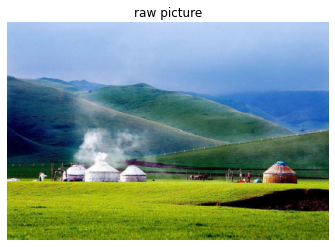

In [21]:
img=Image.open('raw.png')
img=np.array(img)
plt.imshow(img)
plt.title('raw picture')
plt.axis('off')
plt.show()

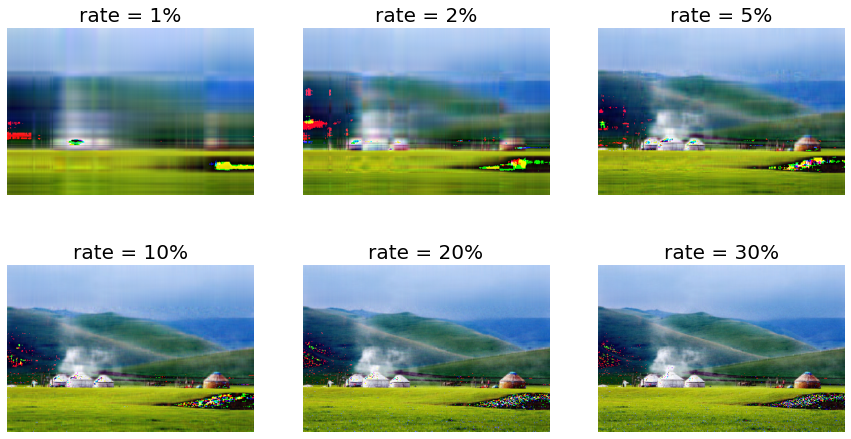

In [26]:
f,axes=plt.subplots(2,3,figsize=(15,8))
axes=axes.reshape(-1)
rate_list=[0.01,0.02,0.05,0.1,0.2,0.3]
for i in range(6):
    rate=rate_list[i]
    ax=axes[i]
    cimg=imgPCA(img,n_components=rate)
    ax.imshow(cimg)
    ax.set_title(f'rate = {int(100*rate)}%',fontsize=20)
    ax.set_axis_off()
plt.show()

# fetch_lfw_people

In [27]:
from sklearn.datasets import fetch_lfw_people
lfw=fetch_lfw_people()

In [28]:
thres=100
frequency = np.bincount(lfw.target)
boolean=np.apply_along_axis(
    lambda x:frequency[x]>=thres,0,lfw.target
    )
X=lfw.data[boolean]
Y=lfw.target[boolean]

In [29]:
X_train,X_test,Y_train,Y_test=\
    train_test_split(X,Y,random_state=1,train_size=0.6)
raw_SVM=LinearSVC(random_state=1,dual=False)
raw_SVM.fit(X_train,Y_train)
Y_pred=raw_SVM.predict(X_test)
score=r2_score(Y_test,Y_pred)
print('>'*20+' Directly use SVM '+'<'*20)
print('accuracy score: ',accuracy_score(Y_test,Y_pred))
print('classification report:\n',
    classification_report(Y_test,Y_pred))

rate_list=[0.01,0.05,0.1,0.3,0.6,0.8]
for i in range(6):
    rate=rate_list[i]
    PCA_model=PCA(n_components=rate)
    pca_X=PCA_model.fit_transform(X)
    X_train,X_test,Y_train,Y_test=\
        train_test_split(pca_X,Y,random_state=1,train_size=0.6)
    PCA_SVM=LinearSVC(random_state=1,dual=False)
    PCA_SVM.fit(X_train,Y_train)
    Y_pred=PCA_SVM.predict(X_test)
    print('>'*20+f' PCA ({int(100*rate)}%) '+'<'*20)
    print('accuracy score: ',accuracy_score(Y_test,Y_pred))
    print('classification report:\n',
        classification_report(Y_test,Y_pred))

>>>>>>>>>>>>>>>>>>>> Directly use SVM <<<<<<<<<<<<<<<<<<<<
accuracy score:  0.8333333333333334
classification report:
               precision    recall  f1-score   support

        1047       0.85      0.86      0.85        91
        1404       0.72      0.84      0.77        51
        1871       0.89      0.90      0.89       216
        1892       0.87      0.58      0.69        45
        5458       0.71      0.74      0.72        53

    accuracy                           0.83       456
   macro avg       0.81      0.78      0.79       456
weighted avg       0.84      0.83      0.83       456

>>>>>>>>>>>>>>>>>>>> PCA (1%) <<<<<<<<<<<<<<<<<<<<
accuracy score:  0.5679824561403509
classification report:
               precision    recall  f1-score   support

        1047       0.48      0.49      0.49        91
        1404       0.00      0.00      0.00        51
        1871       0.65      0.89      0.76       216
        1892       0.54      0.16      0.24        45
        54

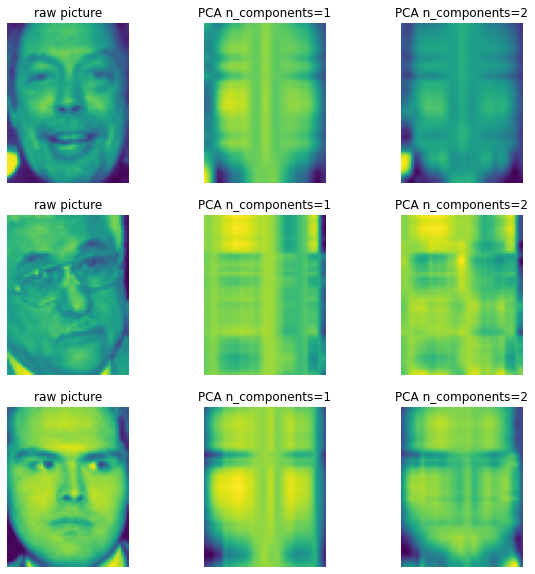

In [36]:
imgs=lfw.images[:3]
f,axes=plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    img=imgs[i]
    for j in range(3):
        ax=axes[i,j]
        if j == 0:
            ax.imshow(img)
            ax.set_title('raw picture')
        else:
            cimg=imgPCA(img,n_components=j,gray=True)
            ax.imshow(cimg)
            ax.set_title(f'PCA n_components={j}')
        ax.set_axis_off()
plt.show()